100%|██████████| 2640397119/2640397119 [04:07<00:00, 10653829.23it/s]


Extracting ./stl10_binary.tar.gz to .


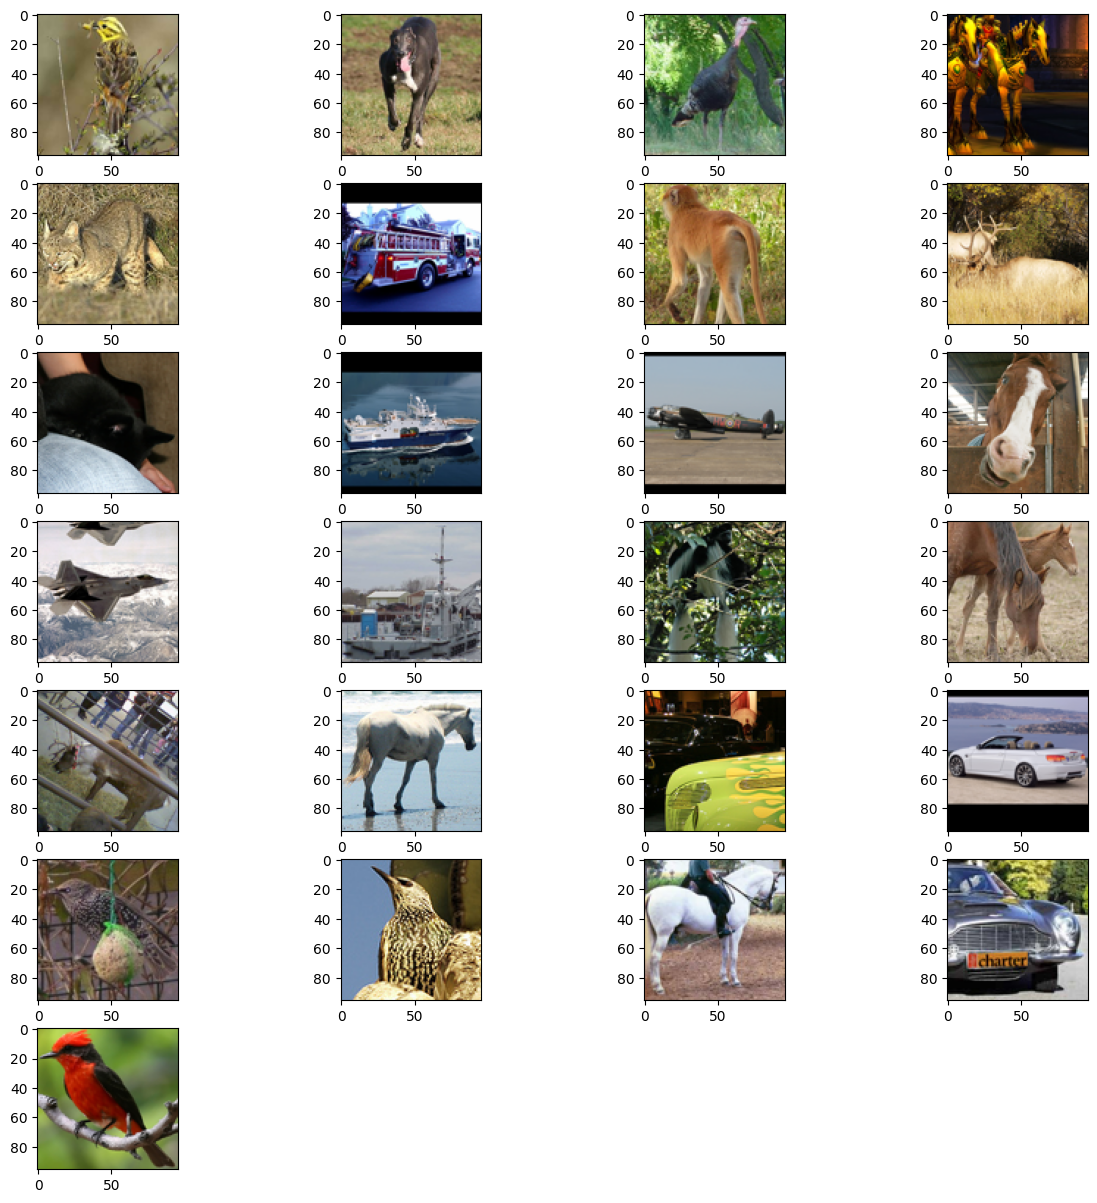

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt


def show_images(datset, num_samples=25, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.STL10(root=".", download=True)
show_images(data)

In [2]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(), #0.5的機率做水平翻轉，原圖也會保留
        transforms.ToTensor(), # Scales data into [0,1] 這個動作會讓hwc變成chw
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.STL10(root=".", download=True,
                                         transform=data_transform)

    test = torchvision.datasets.STL10(root=".", download=True,
                                         transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.), #這一步跟上一步用來反轉ToTensor
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image)) #transforms.Compose不只可以在下載圖片時使用也可以針對圖片使用

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
'''
# my work
from torch.utils.data import Subset

# 假设有一个原始数据集
original_dataset = data

# 假设你只想使用原始数据集中的前100个样本
subset_indices = list(range(386))
subset_dataset = Subset(original_dataset, subset_indices)

# 创建新的 DataLoader
batch_size = 128
subset_data_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
'''

'\n# my work\nfrom torch.utils.data import Subset\n\n# 假设有一个原始数据集\noriginal_dataset = data\n\n# 假设你只想使用原始数据集中的前100个样本\nsubset_indices = list(range(386))\nsubset_dataset = Subset(original_dataset, subset_indices)\n\n# 创建新的 DataLoader\nbatch_size = 128\nsubset_data_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, drop_last=True)\n'

In [5]:
from torch.utils.data import Subset

# 假设有一个原始数据集
original_dataset = data
batch_size = BATCH_SIZE
subset_indices = list(range(((len(data)//BATCH_SIZE) - 1) * BATCH_SIZE))
train_data = Subset(original_dataset, subset_indices)
subset_indices = list(range(((len(data)//BATCH_SIZE) - 1) * BATCH_SIZE , (len(data)//BATCH_SIZE - 1) * BATCH_SIZE + BATCH_SIZE))
valid_data = Subset(original_dataset, subset_indices)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=True)

# 在此做出train 和　validation

In [6]:
# my modified code for the unet in the paper
from torch import nn
import math
# time embedding原本是embedded向量，經過class simple unet裡面的fc+relu後還是向量，接著代入class block裡面又要再做fc+relu最後再broadcasting，所以在unet的每個步驟裡面都要重新對已經fc+relu的embedding值再做一次fc+relu+broadcasting再整個加到圖片裡面

class Blockup(nn.Module): #nn.Module是一個原本就有的class，這邊是說要針對nn.Module為對象做可能的繼承
    def __init__(self, in_ch, out_ch, time_emb_dim): #class constructor
        super().__init__()   # 下這個指令代表所有nn.Module的method(函數)皆可以使用，若在後面括號加入變數名稱如in_ch等等，則會把該變數帶入父類看是否可以繼承父類的屬性‧
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch) #定義class的屬性time_mlp，並且使用nn.Module的函數，其中nn.Linear是單純的fully connected layer, 不包含activation function, first param is input size, second param is output size.
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1) # conv2d, 1st param is number of input's channel, 2nd param is number of output's channel, 3rd param is size of kernel, padding is padding, padding = 1 == padding = (1, 1)也就是前後都補零，若是padding = (1, 0)就只有前面補零,也就只有上跟左補零.
        #另外in_ch乘以2是為了concat residual of the down part.
        self.Tconv2d = nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1) #反卷積，會讓size變大，param are [input channel, output channel, kernel, stride, padding]
        # note that this convtranspose2d會使size變兩倍
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, res): #這裡的t維度為time_emb_dim, 另外如果前傳播函數取名叫做forward，則pytorch在使用模型時會自行調用，使用output = model(input_data)即可
        # First Conv
        h = self.Tconv2d(x)
        h = torch.cat((h, res), dim=1)
        h = self.bnorm1(self.relu(self.conv1(h))) # x代入conv1, 再代入relu, 在做batch normalization
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2] # time_emb.shape從(out_ch,)變成(out_ch, 1, 1)
        # Add time channel
        h = h + time_emb # 這裡h的dim = (128, out_ch, 64, 64) t的dim則是(out_ch, 1, 1)，要做相加就要牽扯到broadcasting, 也就是pytorchc會自動把t的值按照維度去複製成和h相同維度再相加
        # 假設t的維度是(,3) t = [[1, 2, 3]], h維度為(2, 3), h + t會先把t的維度變成(2, 3) 複製t值變成[[1, 2, 3], [1, 2, 3]]
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return h
class Blockdown(nn.Module): #nn.Module是一個原本就有的class，這邊是說要針對nn.Module為對象做可能的繼承
    def __init__(self, in_ch, out_ch, time_emb_dim): #class constructor
        super().__init__()   # 下這個指令代表所有nn.Module的method(函數)皆可以使用，若在後面括號加入變數名稱如in_ch等等，則會把該變數帶入父類看是否可以繼承父類的屬性‧
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch) #定義class的屬性time_mlp，並且使用nn.Module的函數，其中nn.Linear是單純的fully connected layer, 不包含activation function, first param is input size, second param is output size.

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.transform = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t): #這裡的t維度為time_emb_dim, 另外如果前傳播函數取名叫做forward，則pytorch在使用模型時會自行調用，使用output = model(input_data)即可
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x))) # x代入conv1, 再代入relu, 在做batch normalization
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2] # time_emb.shape從(out_ch,)變成(out_ch, 1, 1)
        # Add time channel
        h = h + time_emb # 這裡h的dim = (128, out_ch, 64, 64) t的dim則是(out_ch, 1, 1)，要做相加就要牽扯到broadcasting, 也就是pytorchc會自動把t的值按照維度去複製成和h相同維度再相加
        # 假設t的維度是(,3) t = [[1, 2, 3]], h維度為(2, 3), h + t會先把t的維度變成(2, 3) 複製t值變成[[1, 2, 3], [1, 2, 3]]
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    # A simplified variant of the Unet architecture.
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding 此處建立起embedding模型，給維度即可
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Blockdown(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Blockup(up_channels[i], up_channels[i+1], \
                                        time_emb_dim) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        # dim_his = [x.shape]
        t = self.time_mlp(timestep) # timestep帶入模型，模型會把timestep帶入class SinusoidalPositionEmbeddings裡面的forward的time算出embeddings，其實就是整個timestep的所有embedding的整個向量，此t在此時依然會是向量
        # Initial conv
        x = self.conv0(x) # 3 channel to 64 channel
        # dim_his.append(x.shape)
        # Unet
        residual_inputs = [x]
        for down in self.downs: #down 從 self.downs去找相應模型出來
            x = down(x, t) # (x, t)代入相應模型，也就是代入block裡面的forward，t是向量
            residual_inputs.append(x) # 用來做resudual 的動作
            # dim_his.append(x.shape)
        residual_inputs.pop()

        for up in self.ups:
            residual_x = residual_inputs.pop() #取出residual,這裡面有stack的pop
            # Add residual x as additional channels

            x = up(x, t, residual_x)
            # dim_his.append(x.shape)
        x = self.output(x)
        # dim_his.append(x.shape)
        return x



model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  39458403


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Blockdown(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Blockdown(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [7]:
def get_loss(model, x_0, t): # 此處x_0和t都是batch size
    x_noisy, noise = forward_diffusion_sample(x_0, t, device) # given original image and uniformly sampled t to get the noise and noisy image.
                                                              # of course the x_noise and noise are batch size.
    noise_pred = model(x_noisy, t) # see the definition of the model above, input batch size noisy image and timestep t.
    return F.l1_loss(noise, noise_pred)

In [8]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list( # \frac{1}{\sqrt{1-\bar \alpha_t}}
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape) #\frac{1}{\sqrt{\alpha_t}}

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

In [9]:
# my work
# testing for saving epochs
import shutil

from google.colab import files

from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu" # 檢查是否有可用的 CUDA 設備（通常是顯卡，支援 GPU 運算），如果有，就將 device 變數設置為 "cuda"，否則設置為 "cpu"。
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!
save_interval = 5
for epoch in range(epochs):
    for step, batch in enumerate(train_dataloader):

      optimizer.zero_grad() # 在每個迴圈開始時，將優化器的梯度歸零，以防止梯度累積。

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      # torch.randint 為 randon integer, 1st param is min, 2nd is max, 3rd is size,
      # this function is sampled from uniform distribution, it is sampled for t in the training algorithm.
      loss = get_loss(model, batch[0], t  )
      # batch[0]的dimension為(128, 3, 64, 64)也就是一個batch的feature, batch[1]則是label所以總共有128個label
      # 所以loss這個動作就是把batch裡面的所有圖片都取一個uniform的random後對圖片進行timestep t 的 diffusion process算出noisy image and noise, 再把
      # noisy image, t 送進 unet model算出predicted noise 並且希望這個pred noise 和 真正的nosie 越接近越好
      valid_loss = 0
      loss.backward() # 反向計算梯度
      optimizer.step() # 梯度更新weights
    with torch.inference_mode():
      for step2, batch2 in enumerate(valid_dataloader):
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch2[0], t  )
        valid_loss += loss


    # save the parameters of the model
    if (epoch + 1) % save_interval == 0:
      checkpoint = {
          'epoch': epoch + 1,
          'model_state_dict': model.state_dict(), # model.state_dict()是存下param的的值和形狀
          'optimizer_state_dict': optimizer.state_dict(), # optimizer.state_dict()則是存下優化器的param如momentum等等 不包含當下梯度
          'valid_loss' : valid_loss
          # 可选：保存其他需要的信息，如损失、准确率等
      }
      torch.save(checkpoint, 'model_checkpoint_epoch_{}.pth'.format(epoch + 1))

      source_path = 'model_checkpoint_epoch_{}.pth'.format(epoch + 1)
      destination_path = '/content/drive/MyDrive/Colab Notebooks/weight_save'

      # save them to the google drive
      shutil.copy(source_path, destination_path)

    if epoch % 5 == 0 and step == 0:
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()}, Valid_Loss: {valid_loss.item()} ")
      sample_plot_image()
# 最后保存完整的模型
torch.save(model.state_dict(), 'final_model.pth')

